# Import Statements

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import healpy as hp

# Opening the File to see the list of parameters

### Pass 5.1

In [2]:
pass5file = '/home/rykore/pass5.1/2.63_3.45e-11_1000000_35_1.0_combined_rec.root'

with uproot.open(pass5file) as file:
    t = file['XCDF']
    t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.status           | uint64_t                 | AsDtype('>u8')
rec.version          | uint64_t                 | AsDtype('>u8')
rec.eventID          | uint64_t                 | AsDtype('>u8')
rec.runID            | uint64_t                 | AsDtype('>u8')
rec.timeSliceID      | uint64_t                 | AsDtype('>u8')
rec.trigger_flags    | uint64_t                 | AsDtype('>u8')
rec.event_flags      | uint64_t                 | AsDtype('>u8')
rec.gtc_flags        | uint64_t                 | AsDtype('>u8')
rec.gpsSec           | uint64_t                 | AsDtype('>u8')
rec.gpsNanosec       | uint64_t                 | AsDtype('>u8')
rec.nChTot           | uint64_t                 | AsDtype('>u8')
rec.nChAvail         | uint64_t                 | AsDtype('>u8')
rec.nHitTot          | uint64_t                 | AsDtype(

### Pass 4

In [3]:
pass4file = '/home/rykore/pass4/2.63_3.45e-11_1000000_0_1.0_combined_rec.root'

with uproot.open(pass4file) as file:
    t = file['XCDF']
    t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.nFit             | uint64_t                 | AsDtype('>u8')
rec.status           | uint64_t                 | AsDtype('>u8')
rec.version          | uint64_t                 | AsDtype('>u8')
rec.eventID          | uint64_t                 | AsDtype('>u8')
rec.runID            | uint64_t                 | AsDtype('>u8')
rec.timeSliceID      | uint64_t                 | AsDtype('>u8')
rec.trigger_flags    | uint64_t                 | AsDtype('>u8')
rec.event_flags      | uint64_t                 | AsDtype('>u8')
rec.gtc_flags        | uint64_t                 | AsDtype('>u8')
rec.gpsSec           | uint64_t                 | AsDtype('>u8')
rec.gpsNanosec       | uint64_t                 | AsDtype('>u8')
rec.nChTot           | uint64_t                 | AsDtype('>u8')
rec.nChAvail         | uint64_t                 | AsDtype(

# Redefining variables based on what is needed

According to the paper, https://arxiv.org/pdf/1805.01847
nHit - multiplicity threshold
CxPE40XnCh - 40 m from the core position
zenith angle - between 0 and 60
corsikaParticleId != 1 - don't include gamma rays


### Pass 5.1

In [4]:
dset = dict()

with uproot.open(pass5file) as file:
    t = file['XCDF']
    dset["zenithAngle"] = t["rec.zenithAngle"].array(library="np")
    dset["azimuthAngle"] = t["rec.azimuthAngle"].array(library="np")
    dset["nHit"] = t["rec.nHit"].array(library="np")  # nHit > 75 - new cut
    dset["protonlheEnergy"] = t["rec.protonlheEnergy"].array(library="np")  # reconstructed proton energy
    dset["PINC"] = t["rec.PINC"].array(library="np")
    dset["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np") 
    dset["angleFitStatus"] = t["rec.angleFitStatus"].array(library="np")
    dset["coreFitStatus"] = t["rec.coreFitStatus"].array(library="np")
    # fit status of the reconstruction, 0 meaning successfull and != 0 means unsuccessful
    dset["cuts"] = np.logical_and(dset["angleFitStatus"] == 0, dset["coreFitStatus"] == 0)
    dset["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
    dset["weights"] = t["sweets.IWgt"].array(library="np")
    # corsikaParticleId != 1 - Excludes gamma rays
    dset["cuts"] = np.logical_and(dset["cuts"] , dset["corsikaParticleId"]!=1 , dset["nHit"] > 75)
    # dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2, dset["CxPE40XnCh"] > 40)
    dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2)
    dset["logEnergy"] = t["mc.logEnergy"].array(library="np")  # true energy
    dset["logNNEnergy"] = t["rec.logNNEnergy"].array(library="np")  # reconstructed energy

In [5]:
initial_cuts_5 = dset["cuts"]
zenith_angle_5 = dset["zenithAngle"][initial_cuts_5]
nHit_5 = dset["nHit"][initial_cuts_5]
pinc_5 = dset["PINC"][initial_cuts_5]
true_log_E_5 = dset["logEnergy"][initial_cuts_5]
rec_log_nnE_5 = dset["logNNEnergy"][initial_cuts_5]
rec_prot_E_5 = ((dset["protonlheEnergy"][initial_cuts_5]) - 9)
weights_5 = dset["weights"][initial_cuts_5]

In [6]:
pass_5_dict = {'zenith': zenith_angle_5, 'nHit': nHit_5, 'pinc': pinc_5, 'true energy': true_log_E_5, 'rec nn energy': rec_log_nnE_5,
              'rec proton energy': rec_prot_E_5, 'weight': weights_5}

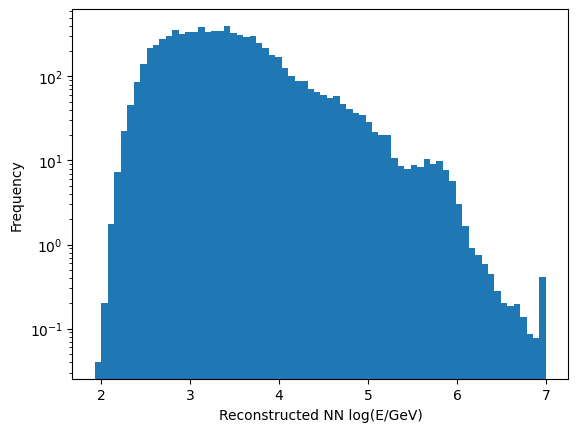

In [7]:
# adding weights - gives the simulated data a weight to make it closer to the actual data
plt.hist(pass_5_dict['rec nn energy'], bins = 70, log=True, weights = weights_5)
plt.xlabel("Reconstructed NN log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

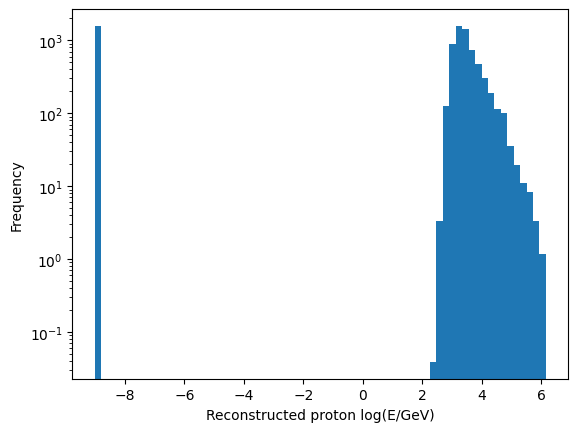

In [8]:
# when the cuts are applied, that -ve log value automatically gets excluded
plt.hist(pass_5_dict['rec proton energy'], bins = 70, log=True, weights = weights_5)
plt.xlabel("Reconstructed proton log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

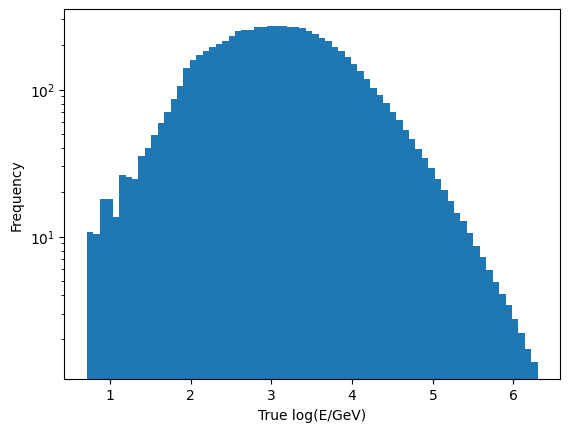

In [9]:
plt.hist(pass_5_dict['true energy'], bins = 70, log=True, weights = weights_5)
plt.xlabel("True log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

### Pass 4

In [10]:
dset = dict()

with uproot.open(pass4file) as file:
    t = file['XCDF']
    dset["zenithAngle"] = t["rec.zenithAngle"].array(library="np")
    dset["azimuthAngle"] = t["rec.azimuthAngle"].array(library="np")
    dset["nHit"] = t["rec.nHit"].array(library="np")  # nHit > 75 - new cut
    dset["protonlheEnergy"] = t["rec.protonlheEnergy"].array(library="np")  # reconstructed proton energy
    dset["PINC"] = t["rec.PINC"].array(library="np")
    dset["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np") 
    dset["angleFitStatus"] = t["rec.angleFitStatus"].array(library="np")
    dset["coreFitStatus"] = t["rec.coreFitStatus"].array(library="np")
    # fit status of the reconstruction, 0 meaning successfull and != 0 means unsuccessful
    dset["cuts"] = np.logical_and(dset["angleFitStatus"] == 0, dset["coreFitStatus"] == 0)
    dset["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
    dset["weights"] = t["sweets.IWgt"].array(library="np")
    # corsikaParticleId != 1 - Excludes gamma rays
    dset["cuts"] = np.logical_and(dset["cuts"] , dset["corsikaParticleId"]!=1 , dset["nHit"] > 75)
    # dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2, dset["CxPE40XnCh"] > 40)  # as per the paper
    dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2)
    dset["logEnergy"] = t["mc.logEnergy"].array(library="np")  # true energy
    dset["logNnEnergy"] = t["rec.logNnEnergy"].array(library="np")  # reconstructed energy

In [11]:
initial_cuts_4 = dset["cuts"]
zenith_angle_4 = dset["zenithAngle"][initial_cuts_4]
nHit_4 = dset["nHit"][initial_cuts_4]
pinc_4 = dset["PINC"][initial_cuts_4]
true_log_E_4 = dset["logEnergy"][initial_cuts_4]
rec_log_nnE_4 = dset["logNnEnergy"][initial_cuts_4]
rec_prot_E_4 = ((dset["protonlheEnergy"][initial_cuts_4]) - 9)
weights_4 = dset["weights"][initial_cuts_4]

In [12]:
pass_4_dict = {'zenith': zenith_angle_4, 'nHit': nHit_4, 'pinc': pinc_4, 'true energy': true_log_E_4, 'rec nn energy': rec_log_nnE_4,
              'rec proton energy': rec_prot_E_4, 'weight': weights_4}

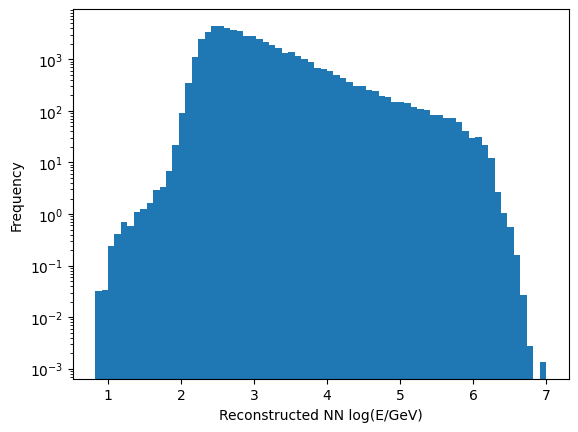

In [13]:
# adding weights - gives the simulated data a weight to make it closer to the actual data
plt.hist(pass_4_dict['rec nn energy'], bins = 70, log=True, weights = weights_4)
plt.xlabel("Reconstructed NN log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

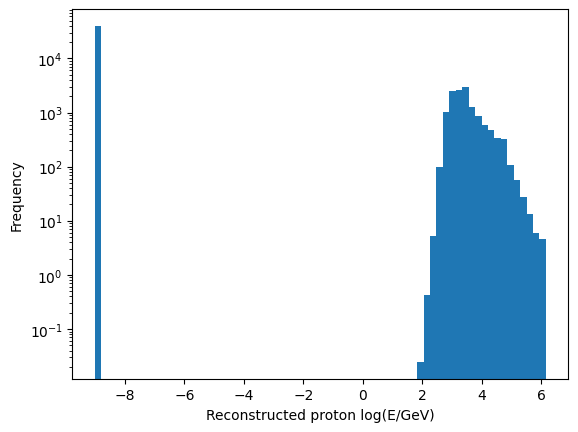

In [14]:
plt.hist(pass_4_dict['rec proton energy'], bins = 70, log=True, weights = weights_4)
plt.xlabel("Reconstructed proton log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

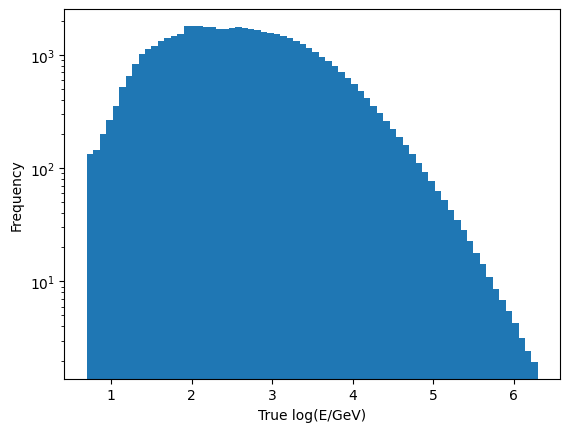

In [15]:
plt.hist(pass_4_dict['true energy'], bins = 70, log=True, weights = weights_4)
plt.xlabel("True log(E/GeV)")
plt.ylabel("Frequency")
plt.show()

# 3D Histogram to visualize the cuts

In [16]:
# Fill histogram with weighted data
def fillHist(h, d, weights,validation = False, nfiles=1):

    # Histogram values
    x = np.cos(np.asarray(d['zenith']))
    y = np.log10(d['nhit'])
    e = d['energy']
    # print(x)

    h0, bins = h
    
    # for k in d:
    #     print(k, d[k].shape)

    # Weight events
    w = weights

    if np.inf in w:        # Set infinite weights to zero
        w[w==np.inf] = 0

    if validation:
        h_train, h_valid = h0
        cut = np.random.uniform(size=x.shape) > 0.2
        h_train += np.histogramdd(np.transpose([x[cut], y[cut], e[cut]]),
                   bins=bins[1:], weights=w[cut])[0]
        h_valid += np.histogramdd(np.transpose([x[~cut], y[~cut], e[~cut]]),
                   bins=bins[1:], weights=w[~cut])[0]
        h0 = np.array([h_train, h_valid])

    else:

        
        h0 += np.histogramdd(np.transpose([x, y, e]), bins=bins, weights=w)[0]
        

    return (h0, bins)

def histPercentile(h, p, binMids):
    tot = h.sum()
    if tot == 0:
        return 0
    p_idx = np.where(h.cumsum()/tot > p/100)[0][0]
    return binMids[p_idx]

def histVar(h, binMids):
    if h.sum() == 0:
        return 0
    vals = np.asarray(binMids)
    ave = np.average(vals, weights=h)
    var = np.average((vals-ave)**2, weights=h)
    return var

def histMedian(h, bins):

    # Assume you only want to operate on the last dimension
    nx, ny, nz = h.shape
    median, sigL, sigR, var = np.zeros((4,nx,ny))
    emids = (bins[-1][:-1] + bins[-1][1:]) / 2
    for i in range(nx):
        for j in range(ny):
            median[i][j] = histPercentile(h[i][j], 50, emids)
            sigL[i][j]   = histPercentile(h[i][j], 16, emids)
            sigR[i][j]   = histPercentile(h[i][j], 84, emids)
            var[i][j]    = histVar(h[i][j], emids)

    return median, sigL, sigR, var


def cmap_discretize(cmap, bins):

    bins = np.array(bins)
    N = len(bins) - 1
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    diffs = bins[1:] - bins[:-1]
    diffs /= diffs.sum()
    indices = np.zeros(len(bins))
    for i, diff in enumerate(diffs):
        indices[i+1] = indices[i] + diff
    indices[-1] = 1
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) \
                for i in range(N+1)]
    return matplotlib.colors.LinearSegmentedColormap('Custom', cdict, 1024)

In [17]:
bin_sizes = {'coszen':30,'nhit':30, 'energy':12}

def make_energy_histo(rec_energy, zenith_angle, energy_weights, pinc_data, true_energy, nhit_data 
                      ,bin_sizes, emin=2, emax=6, coszenmin=0.3,coszenmax=1, nhitmin=1.5
                      ,nhitmax=3.1 ,title="HAWC Energy Response"):
    
    coszen_bins = np.linspace(0.5,1,bin_sizes['coszen'])
    hit_bins = np.linspace(1.7,3.0,bin_sizes['nhit'])
    ebins = np.linspace(emin, emax, bin_sizes['energy'])
    nx, ny, ne = len(coszen_bins)-1, len(hit_bins)-1, len(ebins)-1

    #h = (np.zeros((2, nx, ny, ne)), [[0,1,2], coszen_bins, hit_bins, ebins])
    h = (np.zeros((nx, ny, ne)), [coszen_bins, hit_bins, ebins])
    # cuts = dataset["mc"]["cuts"]
    #cuts = dataset["mc"]["logEnergy"]>.9
    energy = rec_energy
    zenith = zenith_angle
    weights = energy_weights
    pinc = pinc_data
    # cxpe40x = dataset["mc"]["CxPE40XnCh"][cuts]
    mcenergy = true_energy
    nhit = nhit_data


    d = {"zenith":zenith, "energy": mcenergy, "nhit":nhit}

    histo = fillHist(h, d, weights,validation = False,nfiles=1)

    #print(histo)
    h, bins = histo

    xbins, ybins, zbins = bins
    #ebins = getEbins() + [8]

        # Calculate spline / median energy values
    energies, sigL, sigR, var = histMedian(h, bins)


    # Additional options
    #energies[energies==0] = energies.max()      # 0 events only at high E
    #  - finer binning for x & y if using splines?
     #  - cmap.set_under('white')

     # Plot formatting
    # fig, ax = plt.subplots(figsize=(10,8))
    fig, ax = plt.subplots(figsize=(5,4))
    plt.rc("font", family="serif")
    tPars = {'fontsize':16}
    cmap = plt.cm.jet
    #cmap = cmap_discretize(cmap, ebins)
    cmap.set_under('white')

    # Plot
    X, Y = np.meshgrid(xbins, ybins)
    X_c, Y_c = np.meshgrid(xbins[1:], ybins[1:])
    # print(X.shape)
    p = ax.pcolor(X, Y, energies.T, cmap=cmap, vmin=ebins[0], vmax=ebins[-1])
    #cx = ax.contour(X_c, Y_c, energies.T, np.log10([2e3, 3e3, 4.4e3, 7e3, 11e3, 19e3, 3e4, 7e4, 9e4]))
    cx = ax.contour(X_c, Y_c, energies.T, [3.5, 3.75, 4, 4.5, 5, 5.25, 5.5])
    # print(cx.collections[0].get_paths())
    cb = fig.colorbar(p, ax=ax, ticks=ebins)
    cb.ax.set_yticklabels(['%.2f' % ebin for ebin in ebins])
    cb.set_label(r'$\mathrm{log}_{10}(E/\mathrm{GeV})$',
                rotation=270, labelpad=20, **tPars)
    ax.set_xlabel(r'$\mathrm{cos}(\theta_\mathrm{reco})$', **tPars)
    ax.set_ylabel(r'$\mathrm{log}_{10}(N_\mathrm{Hit})$', **tPars)
    #ax.set_xlim(xbins.min(), xbins.max())
    #ax.set_ylim(ybins.min(), ybins.max())
    for item in (ax.get_xticklabels() + ax.get_yticklabels() + cb.ax.get_yticklabels()):
        item.set_fontsize(16)

    for item in cb.ax.get_yticklabels():
        item.set_fontsize(14)
    plt.title(title)
    plt.show()

    return cx

In [18]:
# found on stack overflow
def get_contour_verts(cn):
    contours = []
    # for each contour line
    for cc in cn.collections:
        paths = []
        # for each separate section of the contour line
        for pp in cc.get_paths():
            xy = []
            # for each segment of that section
            for vv in pp.iter_segments():
                xy.append(vv[0])
            paths.append(np.vstack(xy))
        contours.append(paths)

    return contours

def contour_lines_dict(contours):
    lines_dict = {}
    for i, line in enumerate(contours):
        x_coords = []
        y_coords = []
        for section in line:
            x_coords.extend(section[:, 0])
            y_coords.extend(section[:, 1])
        if len(x_coords) != 0:
            lines_dict[f'line{i}'] = (np.array(x_coords), np.array(y_coords))

    return lines_dict

In [19]:
pass_5_dict.keys()

dict_keys(['zenith', 'nHit', 'pinc', 'true energy', 'rec nn energy', 'rec proton energy', 'weight'])

In [20]:
def polynomial_func(lines_dict, zenith):
    vertices_dict = {}
    for i, line in enumerate(lines_dict.keys()):
        x_data = lines_dict[line][0]
        y_data = lines_dict[line][1]

        if x_data.size == 0 or y_data.size == 0:
            continue
        
        # using a degree 3 polynomial - try with degree 2 or 4 also to see accuracy
        p = np.polyfit(x_data, y_data, 2)
        x_fit = np.cos(zenith)
        y_fit = np.zeros_like(x_fit)
        for j in range(len(p)):
            y_fit += p[j] * (x_fit ** (len(p) - 1 - j))
        vertices_dict[f'line{i}'] = (x_fit, y_fit)
    return vertices_dict

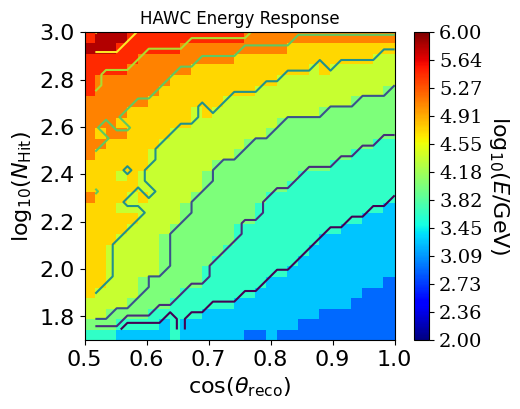

In [21]:
intercept_paths_5 = make_energy_histo(pass_5_dict['rec proton energy'], pass_5_dict['zenith'], pass_5_dict['weight'],
                  pass_5_dict['pinc'], pass_5_dict['true energy'], pass_5_dict['nHit'] 
                      ,bin_sizes,title="HAWC Energy Response")

In [22]:
vertices_5 = get_contour_verts(intercept_paths_5)
lines_dict_5 = contour_lines_dict(vertices_5)
vertices_dict_5 = polynomial_func(lines_dict_5, pass_5_dict['zenith'])

In [23]:
vertices_dict_5

{'line0': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.25858029, 1.95522486, 2.30657042, ..., 1.83152575, 1.81105001,
         1.93106779])),
 'line1': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.55649732, 2.2300156 , 2.59686903, ..., 2.02326718, 1.97884836,
         2.19534142])),
 'line2': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.7417485 , 2.55335319, 2.74477922, ..., 2.30174961, 2.23589525,
         2.51775394])),
 'line3': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.86807186, 2.83431939, 2.84547121, ..., 2.63815436, 2.5804213 ,
         2.81013682])),
 'line4': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.97249685, 2.97576526, 2.95460767, ..., 2.86368779, 2.82942876,
    

In [24]:
# plt.figure(figsize = (7,4))
# for line in vertices_dict_5.keys():
#     # plt.scatter(lines_dict_5[line][0], lines_dict_5[line][1])
#     plt.plot(vertices_dict_5[line][0], vertices_dict_5[line][1])
# plt.ylim(1.5,3.1)
# plt.show()

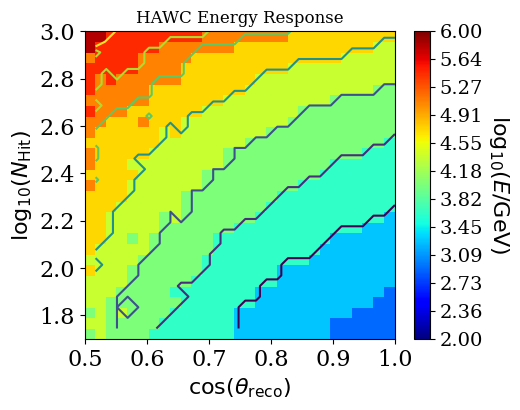

In [25]:
intercept_paths_4 = make_energy_histo(pass_4_dict['rec proton energy'], pass_4_dict['zenith'], pass_4_dict['weight'],
                  pass_4_dict['pinc'], pass_4_dict['true energy'], pass_4_dict['nHit'] 
                      ,bin_sizes,title="HAWC Energy Response")

In [26]:
vertices_4 = get_contour_verts(intercept_paths_4)
lines_dict_4 = contour_lines_dict(vertices_4)
vertices_dict_4 = polynomial_func(lines_dict_4, pass_4_dict['zenith'])

In [27]:
vertices_dict_4

{'line0': (array([0.9646195 , 0.76612909, 0.88115354, ..., 0.63769051, 0.98484817,
         0.48135184]),
  array([2.21472845, 1.85506126, 2.10446786, ..., 1.44309091, 2.23249727,
         0.75158691])),
 'line1': (array([0.9646195 , 0.76612909, 0.88115354, ..., 0.63769051, 0.98484817,
         0.48135184]),
  array([2.51240749, 2.20476208, 2.42304747, ..., 1.83071724, 2.52532387,
         1.18989755])),
 'line2': (array([0.9646195 , 0.76612909, 0.88115354, ..., 0.63769051, 0.98484817,
         0.48135184]),
  array([2.75255194, 2.52287372, 2.69832883, ..., 2.18899524, 2.75643884,
         1.58616264])),
 'line3': (array([0.9646195 , 0.76612909, 0.88115354, ..., 0.63769051, 0.98484817,
         0.48135184]),
  array([2.91567518, 2.81346846, 2.92301063, ..., 2.52727536, 2.90290451,
         1.94559023])),
 'line4': (array([0.9646195 , 0.76612909, 0.88115354, ..., 0.63769051, 0.98484817,
         0.48135184]),
  array([2.9170143 , 2.97740997, 2.99174021, ..., 2.8007388 , 2.88812607,
    

In [28]:
# # ask about this
# plt.figure(figsize = (7,4))
# for line in vertices_dict_4.keys():
#     # plt.scatter(lines_dict_5[line][0], lines_dict_5[line][1])
#     plt.plot(vertices_dict_4[line][0], vertices_dict_4[line][1])

# plt.ylim(1.5,3.1)
# plt.show()

# Cutting and binning the Energy

We use different methods so see which one works best to have consistency and visualize the data

### Method 1: cutting using nHit and cos(zenith)

<!-- cut 0: \$ \log(nHit) < \frac{1.5}{0.35} (x - 0.65) + 2.0 \$  \
cut 1: \$ \log(nHit) > \frac{1.5}{0.35} (x - 0.65) + 2.0 \$ and \$ \log(nHit) < \frac{1.5}{0.35} (x - 0.55) + 2.1 \$  \
cut 2: \$ \log(nHit) > \frac{1.5}{0.35} (x - 0.55) + 2.1 \$ and \$ \log(nHit) < \frac{1.5}{0.35} (x - 0.45) + 2.3 \$  \
cut 3: \$ \log(nHit) > \frac{1.5}{0.35} (x - 0.45) + 2.3 \$ and \$ \log(nHit) < \frac{1.5}{0.35} (x - 0.35) + 2.5 \$  \
cut 4: \$ \log(nHit) > \frac{1.5}{0.35} (x - 0.35) + 2.5 \$ -->

In [29]:
vertices_dict_5

{'line0': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.25858029, 1.95522486, 2.30657042, ..., 1.83152575, 1.81105001,
         1.93106779])),
 'line1': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.55649732, 2.2300156 , 2.59686903, ..., 2.02326718, 1.97884836,
         2.19534142])),
 'line2': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.7417485 , 2.55335319, 2.74477922, ..., 2.30174961, 2.23589525,
         2.51775394])),
 'line3': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.86807186, 2.83431939, 2.84547121, ..., 2.63815436, 2.5804213 ,
         2.81013682])),
 'line4': (array([0.96215317, 0.79103339, 0.98427053, ..., 0.68891878, 0.66753729,
         0.77359592]),
  array([2.97249685, 2.97576526, 2.95460767, ..., 2.86368779, 2.82942876,
    

In [32]:
# need to use interpolated y values to have the same length as nHit and zenith
m1_cuts_dict = {}

def create_cuts_m1(data, nHit, vertices_dict):
    for i in range(len(vertices_dict)):
        # x_data = vertices_dict[f'line{i}'][0]
        y_data = vertices_dict[f'line{i}'][1]

        if i == 0:
            # very first cut
            m1_cuts_dict[f'cut{i}'] = np.log10(nHit) < y_data
        elif i == len(vertices_dict) - 1:
            # last cut
            m1_cuts_dict[f'cut{i}'] = np.log10(nHit) > y_data
        else:
            # prev_x_data = vertices_dict[f'line{i-1}'][0]
            prev_y_data = vertices_dict[f'line{i-1}'][1]

            # check if this condition is correct or not - cos(zenith)
            m1_cuts_dict[f'cut{i}'] = np.logical_and(
                np.log10(nHit) > prev_y_data,
                np.log10(nHit) < y_data
            )
    
    data_cuts = []
    for i in range(len(m1_cuts_dict)):
        data_cut = data[m1_cuts_dict[f'cut{i}']]
        data_cuts.append(data_cut)
    
    return data_cuts

In [266]:
# # maybe compare all the values from the x and y coordinates to each value of nHit and cos(zenith) - but this would take a long time to iterate through
# m1_cuts_dict = {}

# def create_cuts_m1(data, nHit, zenith, vertices_dict):
#     for i in range(len(vertices_dict)):
#         if i == 0:
#             m1_cuts_dict[f'cut{i}'] = np.logical_and(np.log10(nHit) < vertices_dict[f'line{i}'][1], 
#                                                          np.cos(zenith) > vertices_dict[f'line{i}'][0])
#             continue
#         if i == 7:
#             m1_cuts_dict[f'cut{i}'] = np.logical_and(np.log10(nHit) > vertices_dict[f'line{i}'][1], 
#                                                      np.cos(zenith) < vertices_dict[f'line{i}'][0])
#             continue
            
#         m1_cuts_dict[f'cut{i}'] = np.logical_and( vertices_dict[f'line{i-1}'][1] < np.log10(nHit) < vertices_dict[f'line{i}'][1], 
#                                                   vertices_dict[f'line{i-1}'][0] > np.cos(zenith) > vertices_dict[f'line{i}'][0])  
#     data_cuts = []
#     for i in range(len(m1_cuts_dict)):
#         data_cut = data[m1_cuts_dict[f'cut{i}']]
#         data_cuts.append(data_cut)
#     return data_cuts

In [267]:
# m1_cuts_dict = {}
# x_int = 
# y_int = [2.0, 2.1, 2.3, 2.5]
# def create_cuts_m1(data, nHit, zenith, x_int, y_int):
#     slope = 1.5/0.35
#     m1_cuts_dict['cut0'] = np.log10(nHit) < (slope * (np.cos(zenith) - x_int[0])) + y_int[0]
#     m1_cuts_dict['cut1'] = np.logical_and( np.log10(nHit) > (slope * (np.cos(zenith) - x_int[0])) + y_int[0],
#                                            np.log10(nHit) < (slope * (np.cos(zenith) - x_int[1])) + y_int[1])
#     m1_cuts_dict['cut2'] = np.logical_and( np.log10(nHit) > (slope * (np.cos(zenith) - x_int[1])) + y_int[1],
#                                            np.log10(nHit) < (slope * (np.cos(zenith) - x_int[2])) + y_int[2])
#     m1_cuts_dict['cut3'] = np.logical_and( np.log10(nHit) > (slope * (np.cos(zenith) - x_int[2])) + y_int[2],
#                                            np.log10(nHit) < (slope * (np.cos(zenith) - x_int[3])) + y_int[3])
#     m1_cuts_dict['cut4'] = np.log10(nHit) > (slope * (np.cos(zenith) - x_int[3])) + y_int[3]

#     data_cuts = []
#     for i in range(len(m1_cuts_dict)):
#         data_cut = data[m1_cuts_dict[f'cut{i}']]
#         data_cuts.append(data_cut)

#     return data_cuts

In [268]:
pass_5_dict.keys()

dict_keys(['zenith', 'nHit', 'pinc', 'true energy', 'rec nn energy', 'rec proton energy', 'weight'])

In [35]:
# pass 5.1
rec_energy_cuts_5 = create_cuts_m1(pass_5_dict['true energy'], pass_5_dict['nHit'], vertices_dict_5)
rec_weights_cuts_5 = create_cuts_m1(pass_5_dict['weight'], pass_5_dict['nHit'], vertices_dict_5)
rec_zenith_cuts_5 = create_cuts_m1(pass_5_dict['zenith'], pass_5_dict['nHit'], vertices_dict_5)

# pass 4
rec_energy_cuts_4 = create_cuts_m1(pass_4_dict['true energy'], pass_4_dict['nHit'],vertices_dict_4)
rec_weights_cuts_4 = create_cuts_m1(pass_4_dict['weight'], pass_4_dict['nHit'], vertices_dict_4)
rec_zenith_cuts_4 = create_cuts_m1(pass_4_dict['zenith'], pass_4_dict['nHit'], vertices_dict_4)

In [36]:
# checking the output
rec_energy_cuts_5

[array([4.336, 3.502, 3.876, ..., 4.273, 4.105, 4.056]),
 array([4.081, 4.108, 4.282, ..., 3.997, 4.404, 4.215]),
 array([5.412, 4.328, 5.452, ..., 4.743, 4.757, 4.502]),
 array([4.121, 4.909, 4.367, ..., 4.4  , 4.779, 5.761]),
 array([5.576, 4.836, 5.382, ..., 4.656, 4.978, 4.887]),
 array([5.329, 5.72 , 5.535, ..., 5.274, 5.71 , 5.391]),
 array([6.148, 6.04 , 5.644, ..., 5.745, 5.817, 6.152])]

In [37]:
rec_energy_cuts_4

[array([4.336, 3.764, 3.502, ..., 4.193, 3.65 , 3.536]),
 array([4.081, 3.882, 4.108, ..., 3.952, 4.067, 4.905]),
 array([5.412, 4.328, 5.011, ..., 4.964, 4.378, 4.516]),
 array([5.576, 5.074, 4.409, ..., 4.328, 5.54 , 4.437]),
 array([5.242, 4.717, 3.591, ..., 4.464, 4.468, 4.788]),
 array([4.836, 5.382, 5.415, ..., 5.646, 5.088, 4.422]),
 array([5.887, 6.148, 6.04 , 5.644, 6.035, 5.745, 6.154, 5.704, 5.868,
        6.058, 5.988, 6.215, 5.96 , 6.189, 6.219, 6.042, 6.087, 6.091,
        5.621, 6.049, 6.06 , 6.154, 5.952, 5.888, 5.851, 5.964, 5.819,
        6.125, 5.953, 6.213, 5.612, 5.766, 5.543, 6.113, 5.935, 6.128,
        6.103, 5.739, 5.913, 5.79 , 5.96 , 5.806, 6.038, 6.299, 6.163,
        5.718, 5.77 , 5.886, 6.108, 6.141, 6.123, 6.166, 5.84 , 5.835,
        5.761, 5.982, 5.612, 5.523, 6.195, 6.146, 6.029, 5.742, 6.162,
        5.959, 5.669, 6.207, 6.041, 5.909, 6.073, 6.173, 5.9  , 5.629,
        5.88 , 5.951, 5.896, 6.077, 5.713, 5.725, 6.23 , 5.873, 6.102,
        6.038, 5.86

### Method 2: cutting using energy levels

cut 1 = 1 Tev - 10 TeV  \
cut 2 = 10 TeV - 30 TeV\
cut 3 = 30 TeV - 50 TeV\
cut 4 = 50 TeV - 70 TeV\
cut 5 = 70 TeV - 100 TeV\
cut 6 = 100 TeV - 200 TeV\
cut 7 = 200 TeV - 300 TeV

In [46]:
def create_cuts_m2(data, bins):
    cuts_dict = {}
    for i in range(len(bins) - 1):
        cut_name = f"cut{i+1}"
        cuts_dict[cut_name] = np.logical_and(data >= bins[i], data < bins[i+1])
    return cuts_dict

In [47]:
energy_bins_m2 = np.log10([1e3, 1e4, 3e4, 5e4, 7e4, 1e5, 2e5, 3e5])

# pass 5.1
rec_nn_cuts_5 = create_cuts_m2(pass_5_dict['rec nn energy'], energy_bins_m2)
rec_prot_cuts_5 = create_cuts_m2(pass_5_dict['rec proton energy'], energy_bins_m2)

# pass 4
rec_nn_cuts_4 = create_cuts_m2(pass_4_dict['rec nn energy'], energy_bins_m2)
rec_prot_cuts_4 = create_cuts_m2(pass_4_dict['rec proton energy'], energy_bins_m2)

In [48]:
# checking the output
rec_prot_cuts_4

{'cut1': array([ True,  True,  True, ...,  True, False, False]),
 'cut2': array([False, False, False, ..., False,  True, False]),
 'cut3': array([False, False, False, ..., False, False, False]),
 'cut4': array([False, False, False, ..., False, False, False]),
 'cut5': array([False, False, False, ..., False, False, False]),
 'cut6': array([False, False, False, ..., False, False, False]),
 'cut7': array([False, False, False, ..., False, False, False])}

In [49]:
# apply the cuts to energy
def apply_cuts_m2(data, cuts_dict):
    data_array_with_cuts_applied = []
    for cut in cuts_dict.keys():
        data_with_cuts = data[cuts_dict[cut]]
        data_array_with_cuts_applied.append(data_with_cuts)
    return data_array_with_cuts_applied

In [50]:
# nn energy cuts for pass 5.1
nn_energies_5 = apply_cuts_m2(pass_5_dict['true energy'], rec_nn_cuts_5)
nn_weights_array_5 = apply_cuts_m2(pass_5_dict['weight'], rec_nn_cuts_5)
nn_zenith_array_5 = apply_cuts_m2(pass_5_dict['zenith'], rec_nn_cuts_5)

In [51]:
# proton energy cuts for pass 5.1
prot_energies_5 = apply_cuts_m2(pass_5_dict['true energy'], rec_prot_cuts_5)
prot_weights_array_5 = apply_cuts_m2(pass_5_dict['weight'], rec_prot_cuts_5)
prot_zenith_array_5 = apply_cuts_m2(pass_5_dict['zenith'], rec_prot_cuts_5)

In [52]:
# nn energy cuts for pass 4
nn_energies_4 = apply_cuts_m2(pass_4_dict['true energy'], rec_nn_cuts_4)
nn_weights_array_4 = apply_cuts_m2(pass_4_dict['weight'], rec_nn_cuts_4)
nn_zenith_array_4 = apply_cuts_m2(pass_4_dict['zenith'], rec_nn_cuts_4)

In [53]:
# proton energy cuts for pass 4
prot_energies_4 = apply_cuts_m2(pass_4_dict['true energy'], rec_prot_cuts_4)
prot_weights_array_4 = apply_cuts_m2(pass_4_dict['weight'], rec_prot_cuts_4)
prot_zenith_array_4 = apply_cuts_m2(pass_4_dict['zenith'], rec_prot_cuts_4)

# Functions

## Binning the zenith angle

In [38]:
# change the variable names
# 180 degrees divided into 18 bins with each bin being 10 degrees
deltaz = np.radians(5)
zbins = np.arange(min(pass_5_dict['zenith']),max(pass_5_dict['zenith']), deltaz)
print(zbins)

[2.00000000e-04 8.74664626e-02 1.74732925e-01 2.61999388e-01
 3.49265850e-01 4.36532313e-01 5.23798776e-01 6.11065238e-01
 6.98331701e-01 7.85598163e-01 8.72864626e-01 9.60131089e-01
 1.04739755e+00 1.13466401e+00 1.22193048e+00 1.30919694e+00
 1.39646340e+00 1.48372986e+00]


## Weighted Quantile function
input:  \
values = log_E  \
quantiles = \[0.159, 0.841\] (array of what quantiles of the data you need) \
sample_weight = weights (apply cuts on weights as well so that the dimensions of both the arrays remain the same) \
values_sorted (if False, will sort the returned array)  \
output:  \
an interpolated array having the same dimensions as the quantiles array from the input that has the weighted values in the data at those specified quantiles

In [39]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ 
    Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!

    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.

    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

## Plotting the average energy vs zenith angle

In [59]:
deltaz = np.radians(5)
colors = ['black', 'royalblue']

def energy_zenith_plot(energies, weights, zeniths, zbins, colors, titles):
    # define the range as len(number of cuts)
    # put in 7 as of now but change this
    for i in range(len(energies[0])):
        fig, ax = plt.subplots(figsize = (7,4))
        medians = []

        for j, (energy_set, weight_set, zenith_set, color) in enumerate(zip(energies, weights, zeniths, colors)):
            energy = energy_set[i]
            weight = weight_set[i]
            zenith = zenith_set[i]
            median_energy = np.median(energy)
            medians.append(median_energy)

            for z in zbins:
                zmin = z
                zmax = z + deltaz
                zcut = np.logical_and(zenith >= zmin, zenith <= zmax)

                if not sum(weight[zcut] > 0):
                    continue

                # avg_energy = np.average(energy[zcut], weights = weight[zcut])
                median_energy = weighted_quantile(energy[zcut], 0.5, sample_weight = weight[zcut])
                upper_quantile = weighted_quantile(energy[zcut], 0.841, sample_weight = weight[zcut])
                lower_quantile = weighted_quantile(energy[zcut], 0.159, sample_weight = weight[zcut])

                err_upper = upper_quantile - median_energy
                err_lower = median_energy - lower_quantile
                err_lower = np.maximum(np.zeros(err_lower.size),err_lower)

                ax.errorbar(z, median_energy, yerr=[[err_lower], [err_upper]], fmt='o', markersize=8, color=color, label=f'pass{4+j}' if z == zbins[0] else "")

        ax.set_xlabel('Zenith Angle')
        ax.set_ylabel('log(Energy)')
        ax.set_title(f'cut {i}')
        # ax.set_xlim(right = 1)  # 1.05 radians is 60 degrees
        
        proxy_pass4 = plt.Line2D([0], [0], linestyle='--', marker='o', color=colors[0])
        proxy_pass5 = plt.Line2D([0], [0], linestyle='-', marker='o', color=colors[1])
    
        median_pass4 = medians[0] - 3
        median_pass5 = medians[1] - 3
        
        ax.legend([proxy_pass4, proxy_pass5], [f'pass4 (median=$10^{{{median_pass4:.2f}}}$)', f'pass5 (median=$10^{{{median_pass5:.2f}}}$)'])
        
        plt.show()

## Histogram of the cuts with respect to true energy

In [53]:
# for method 1, we have 8 cuts
hist_colors_m1 = ['navy', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red', 'pink']
# for method 2, we have 7 cuts
hist_colors_m2 = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red']

def make_histogram(true_energy, energy_cuts, hist_colors, title):
    plt.figure(figsize = (10,7))
    plt.hist(true_energy, bins = 60, histtype = 'bar', alpha = 0.3, label = "True energy", edgecolor='black', color='grey')
    for i, (cut, color) in enumerate(zip(energy_cuts,hist_colors)):
        plt.hist(cut, bins = 60, histtype = 'bar', alpha = 0.3, label = f"cut {i}, median: {np.median(cut):.2f}", 
                 edgecolor='black', color = color)

    plt.title(title)
    plt.xlabel("log (E/GeV)")
    plt.yscale('log')
    plt.ylabel("log counts")
    plt.legend()
    plt.show()

## Normalized histogram of the cuts

In [56]:
def make_normalized_histogram(energy_cuts, hist_colors, title):
    plt.figure(figsize = (10,7))
    for i, (cut, color) in enumerate(zip(energy_cuts,hist_colors)):
        plt.hist(cut, bins = 60, histtype = 'step', label = f"cut {i}, median: {np.median(cut):.2f}", 
                 density = True, color = color)

    plt.title(title)
    plt.xlabel("log (E/GeV)")
    plt.ylabel("normalized counts")
    plt.legend()
    plt.show()

# Method 1 Analysis

## Energy vs Zenith plots

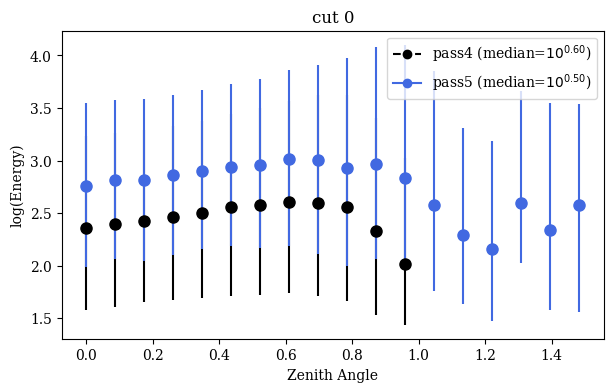

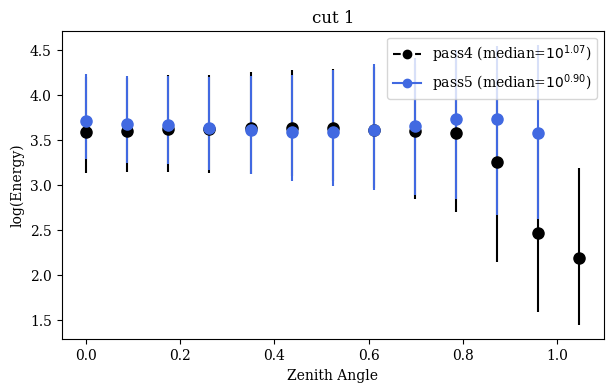

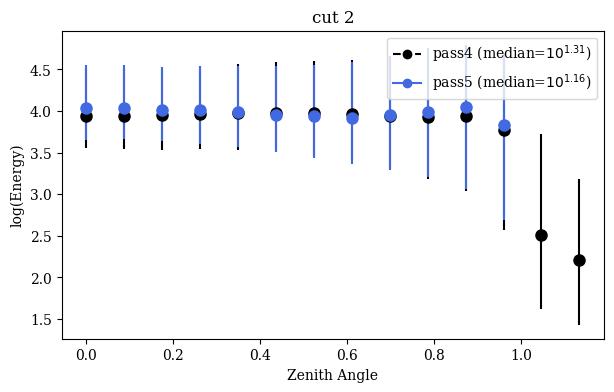

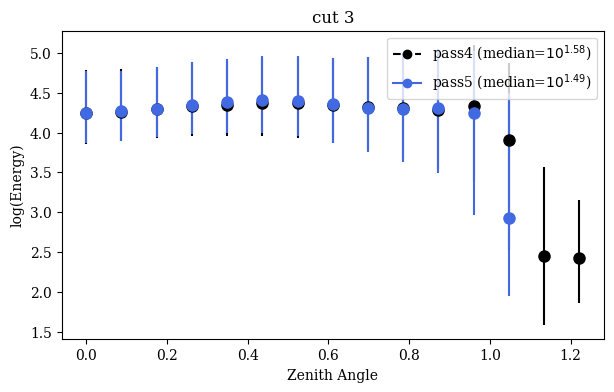

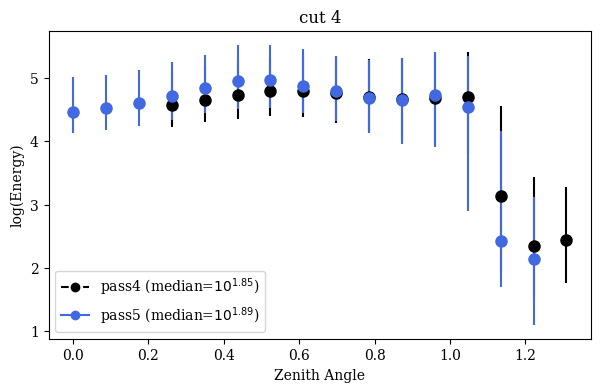

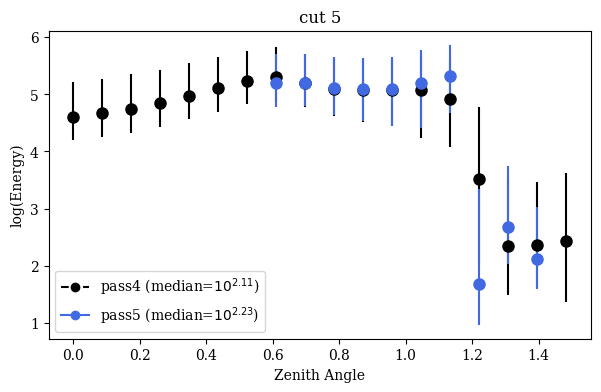

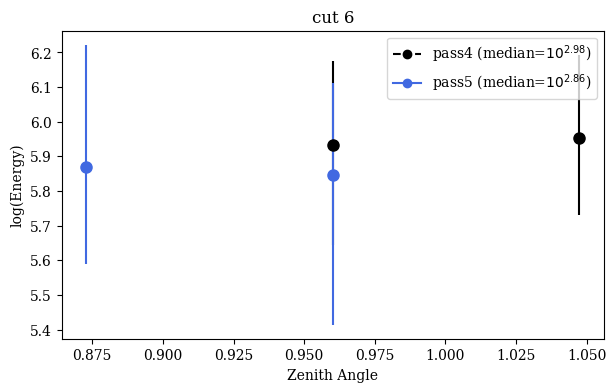

In [60]:
rec_energies = [rec_energy_cuts_4, rec_energy_cuts_5]
rec_weights = [rec_weights_cuts_4, rec_weights_cuts_5]
rec_zeniths = [rec_zenith_cuts_4, rec_zenith_cuts_5]
titles = ['cut 0', 'cut 1', 'cut 2', 'cut 3', 'cut 4', 'cut 5', 'cut 6', 'cut 7']

energy_zenith_plot(rec_energies, rec_weights, rec_zeniths, zbins, colors, titles)

## Histograms

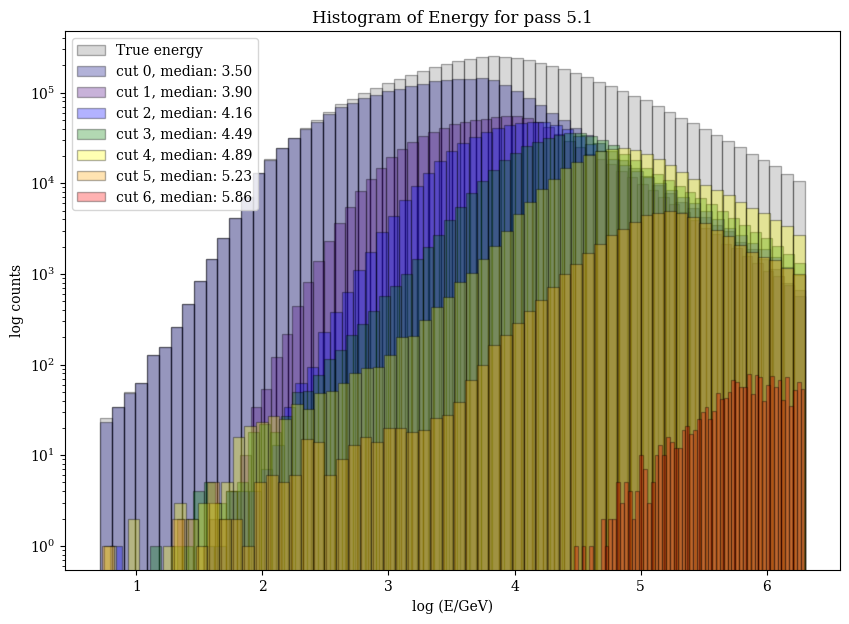

In [54]:
make_histogram(pass_5_dict['true energy'],rec_energy_cuts_5, hist_colors_m1, "Histogram of Energy for pass 5.1" )

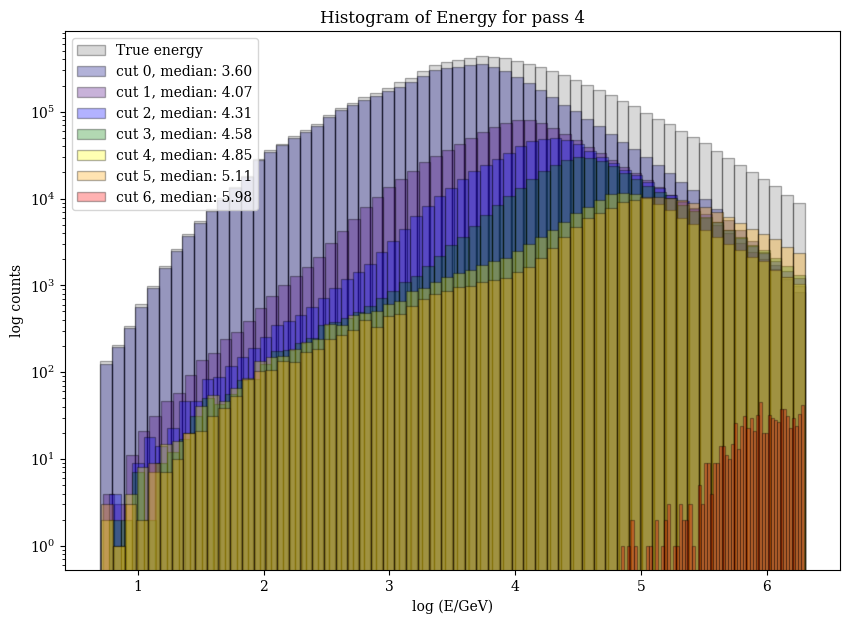

In [55]:
make_histogram(pass_4_dict['true energy'],rec_energy_cuts_4, hist_colors_m1, "Histogram of Energy for pass 4" )

## Normalized Histograms

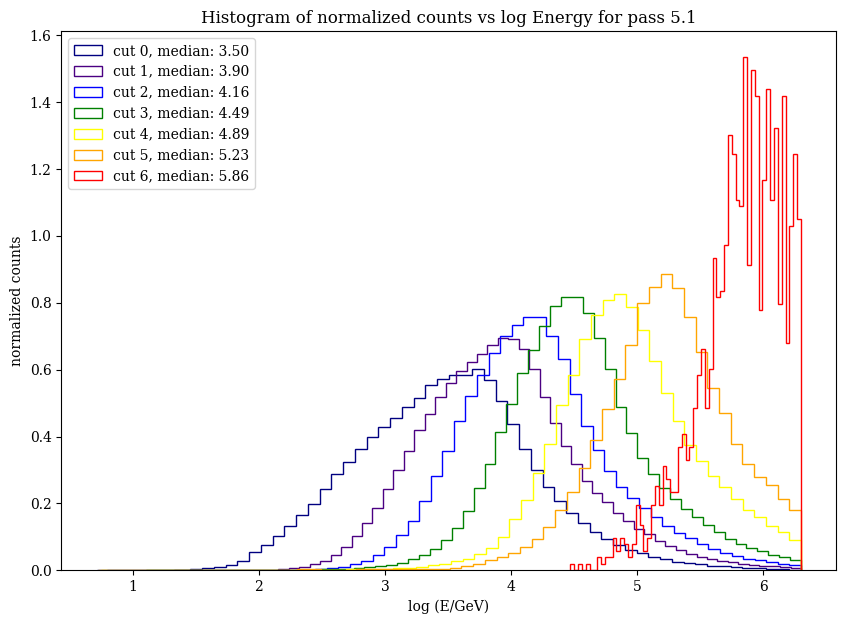

In [57]:
make_normalized_histogram(rec_energy_cuts_5, hist_colors_m1, "Histogram of normalized counts vs log Energy for pass 5.1")

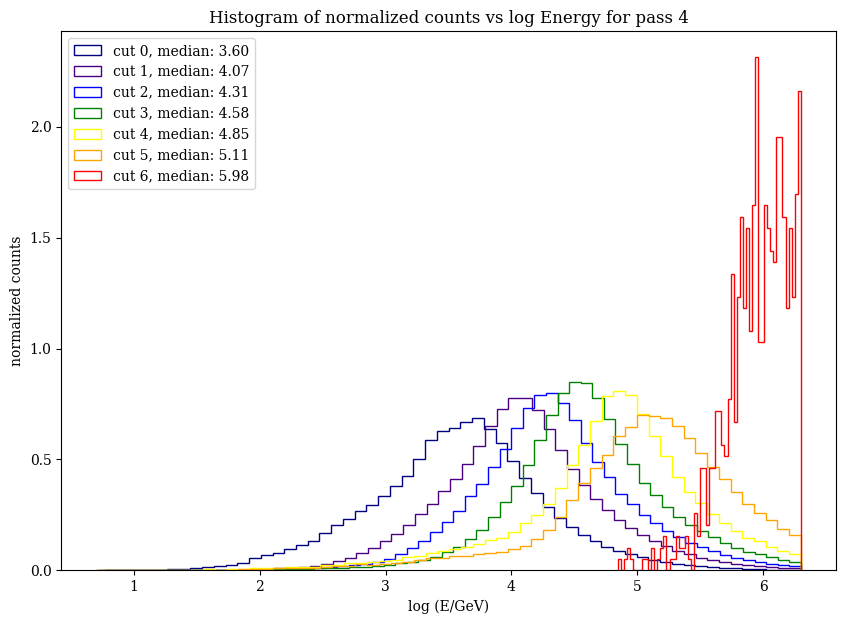

In [58]:
make_normalized_histogram(rec_energy_cuts_4, hist_colors_m1, "Histogram of normalized counts vs log Energy for pass 4")

# Method 2 Analysis

## Evergy vs Zenith Plots

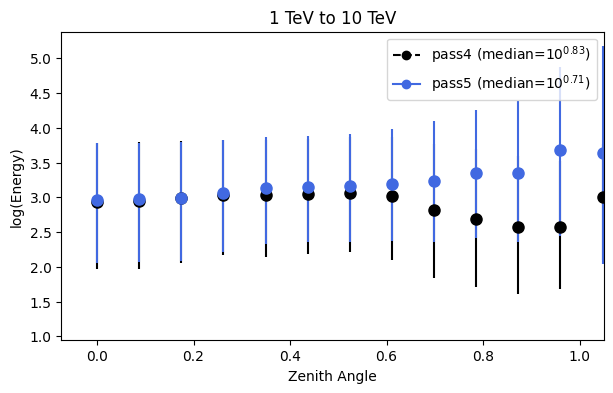

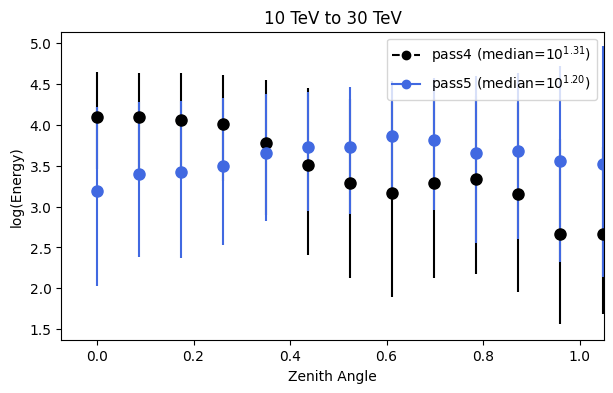

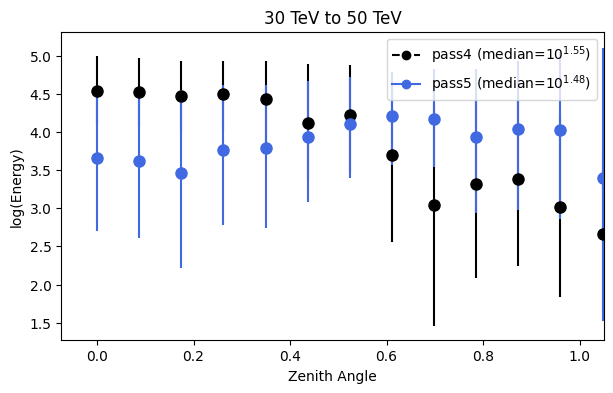

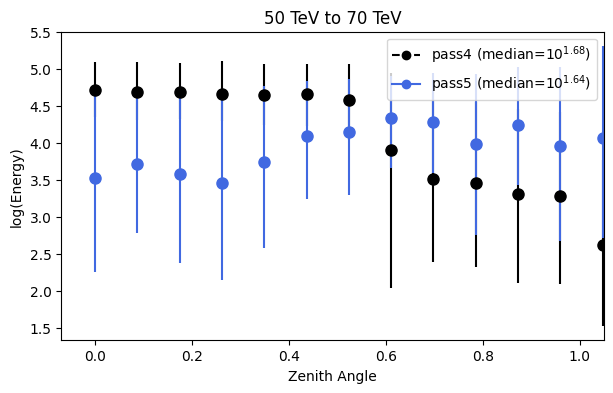

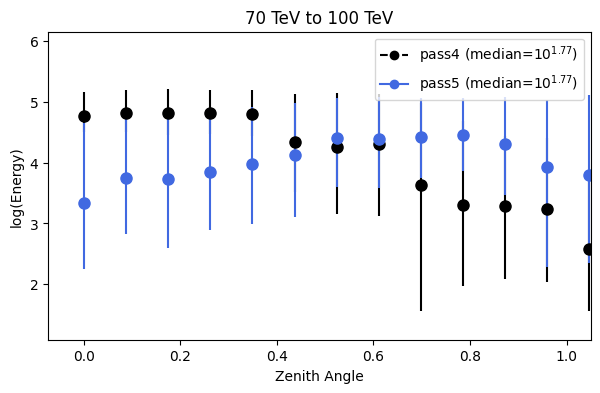

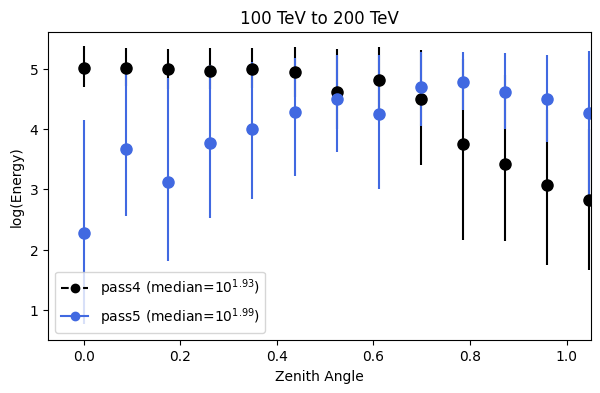

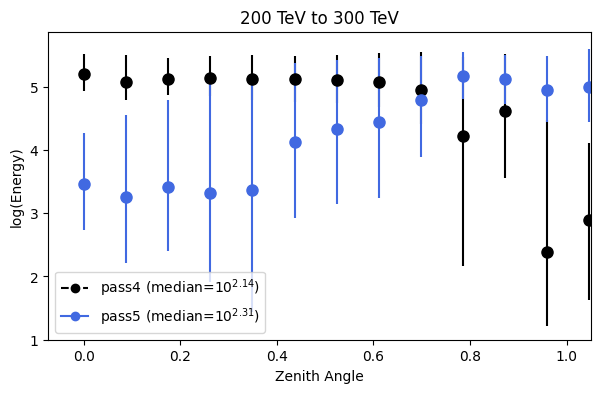

In [41]:
nn_energies = [nn_energies_4, nn_energies_5]
nn_weights_array = [nn_weights_array_4, nn_weights_array_5]
nn_zenith_array = [nn_zenith_array_4, nn_zenith_array_5]
titles = ['1 TeV to 10 TeV', '10 TeV to 30 TeV', '30 TeV to 50 TeV', '50 TeV to 70 TeV', '70 TeV to 100 TeV', '100 TeV to 200 TeV', '200 TeV to 300 TeV']

energy_zenith_plot(nn_energies, nn_weights_array, nn_zenith_array, zbins, colors, titles)

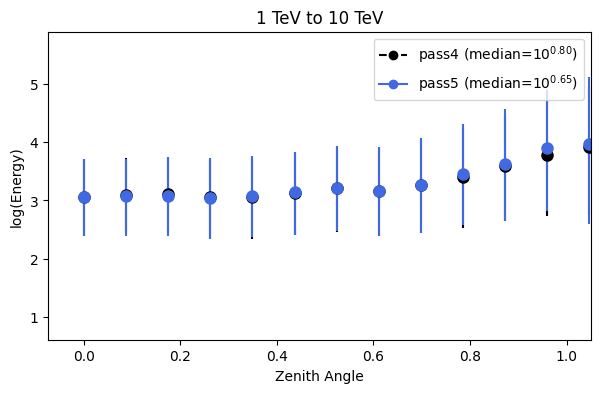

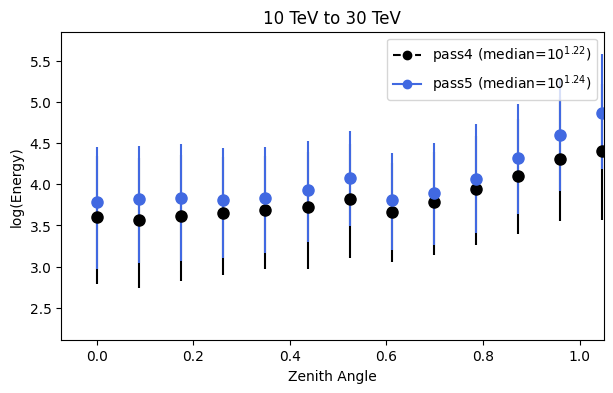

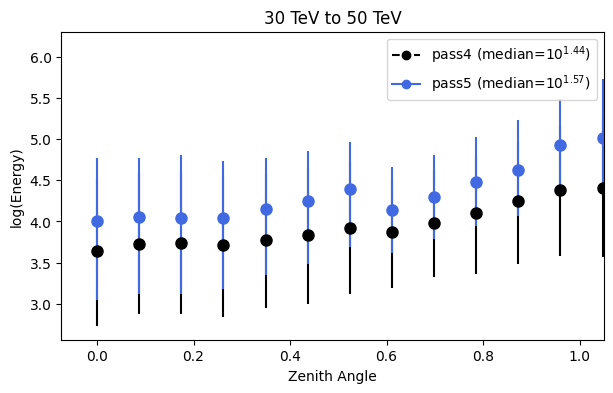

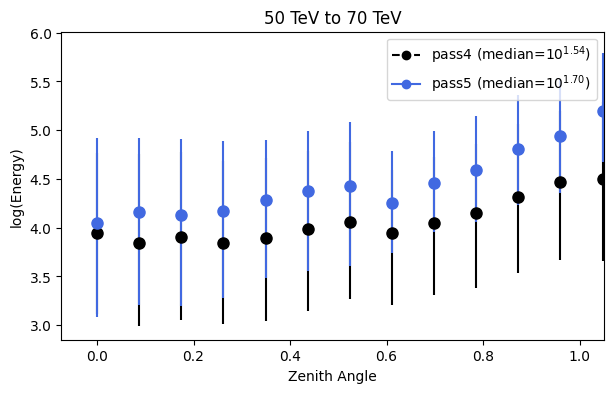

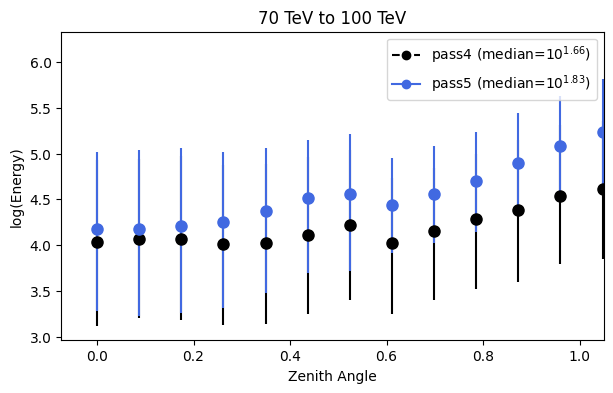

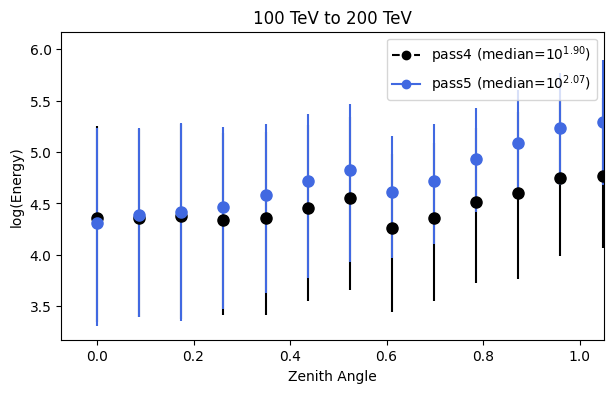

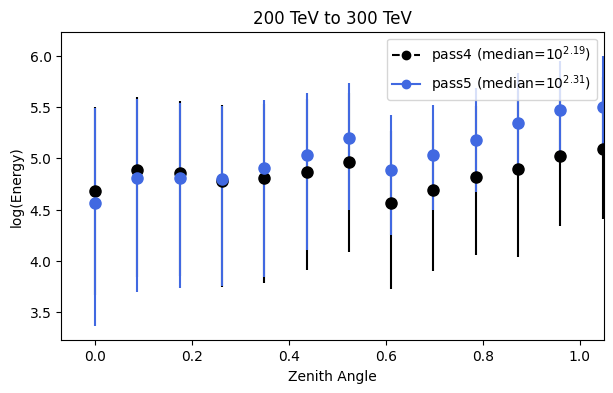

In [42]:
# applying the reconstructed nn energy cuts on true energy and add weights to them then plot it with the zenith

prot_energies = [prot_energies_4, prot_energies_5]
prot_weights_array = [prot_weights_array_4, prot_weights_array_5]
prot_zenith_array = [prot_zenith_array_4, prot_zenith_array_5]

energy_zenith_plot(prot_energies, prot_weights_array, prot_zenith_array, zbins, colors, titles)

## Histograms

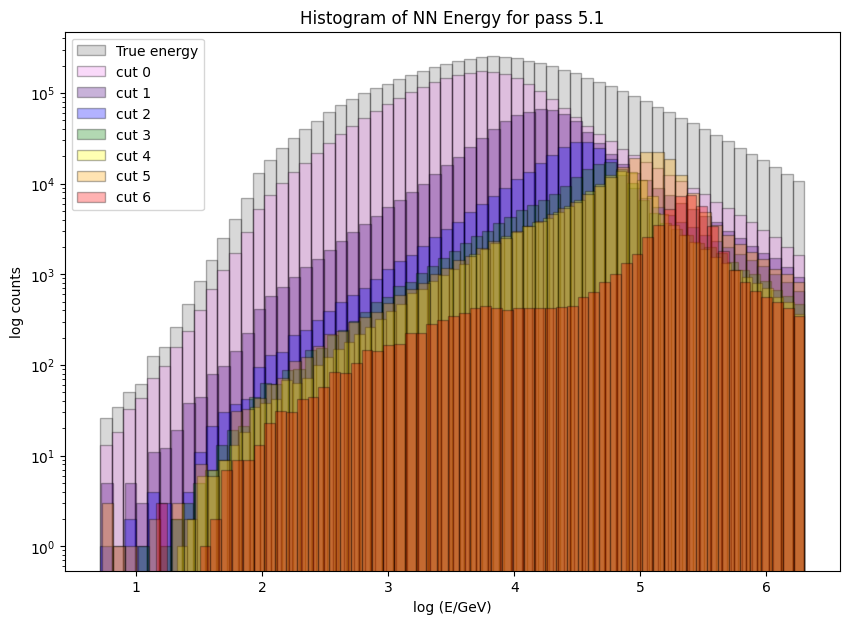

In [63]:
make_histogram(pass_5_dict['true energy'],nn_energies_5, hist_colors_m2, "Histogram of NN Energy for pass 5.1" )

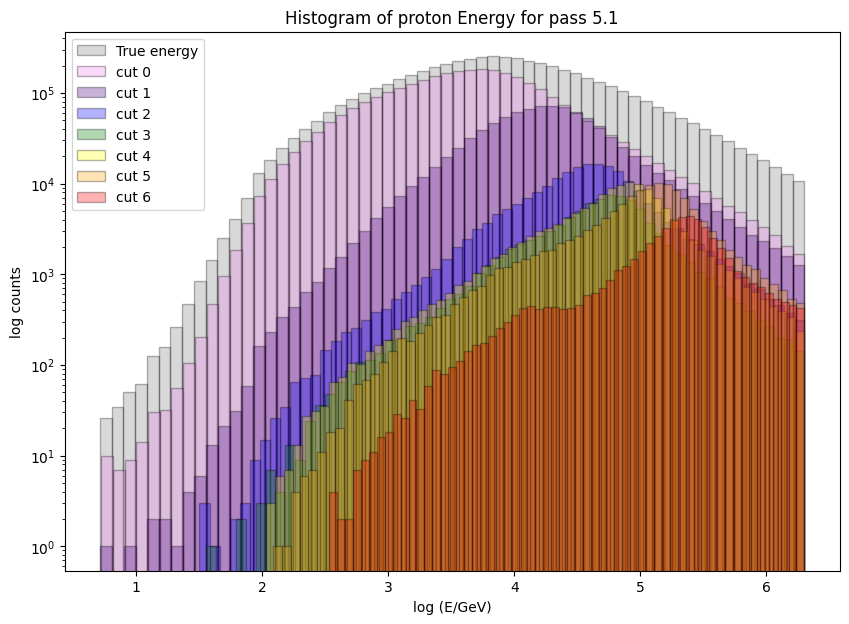

In [65]:
make_histogram(pass_5_dict['true energy'],prot_energies_5, hist_colors_m2, "Histogram of proton Energy for pass 5.1" )

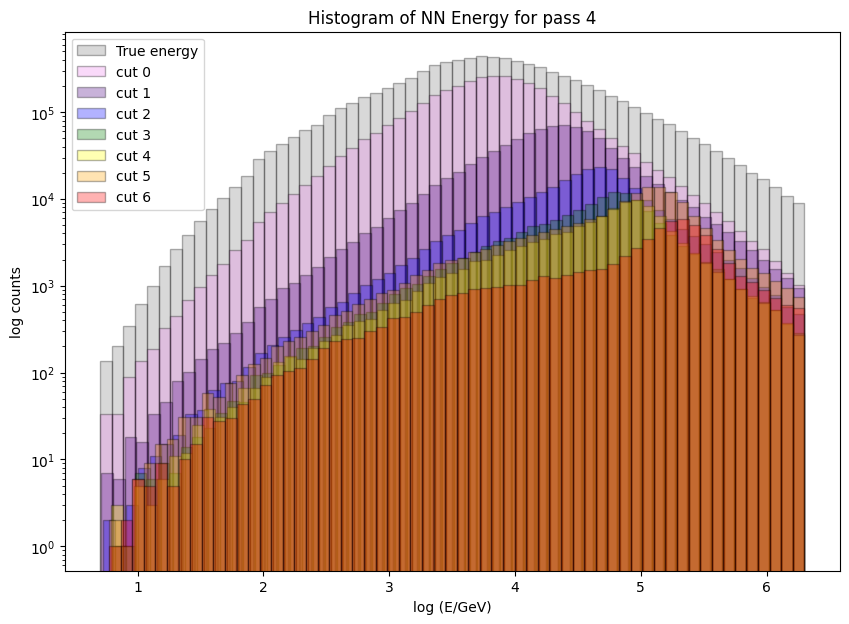

In [66]:
make_histogram(pass_4_dict['true energy'],nn_energies_4, hist_colors_m2, "Histogram of NN Energy for pass 4" )

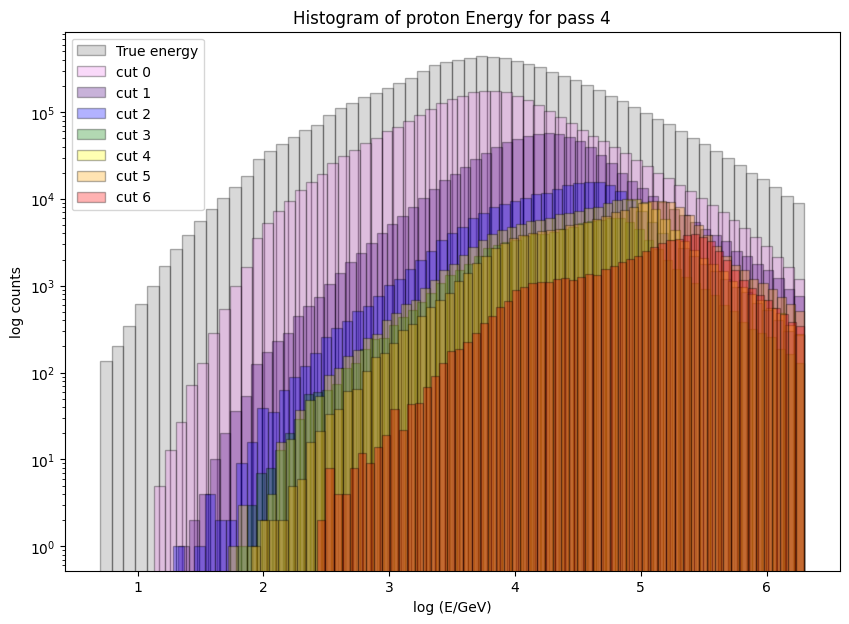

In [67]:
make_histogram(pass_4_dict['true energy'],prot_energies_4, hist_colors_m2, "Histogram of proton Energy for pass 4" )

## Normalized Histograms

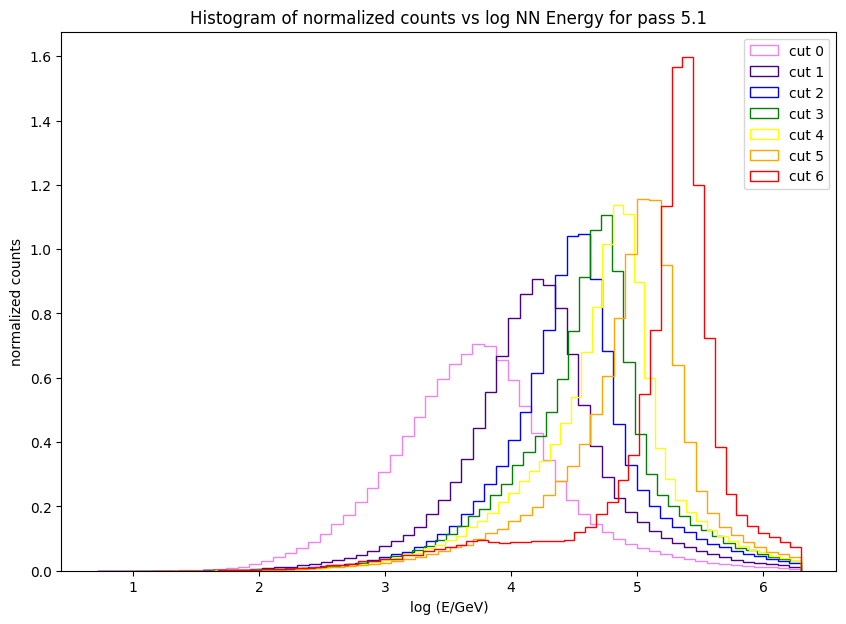

In [68]:
# normalizing the counts for pass 5.1 - rec nn energy
make_normalized_histogram(nn_energies_5, hist_colors_m2, "Histogram of normalized counts vs log NN Energy for pass 5.1")

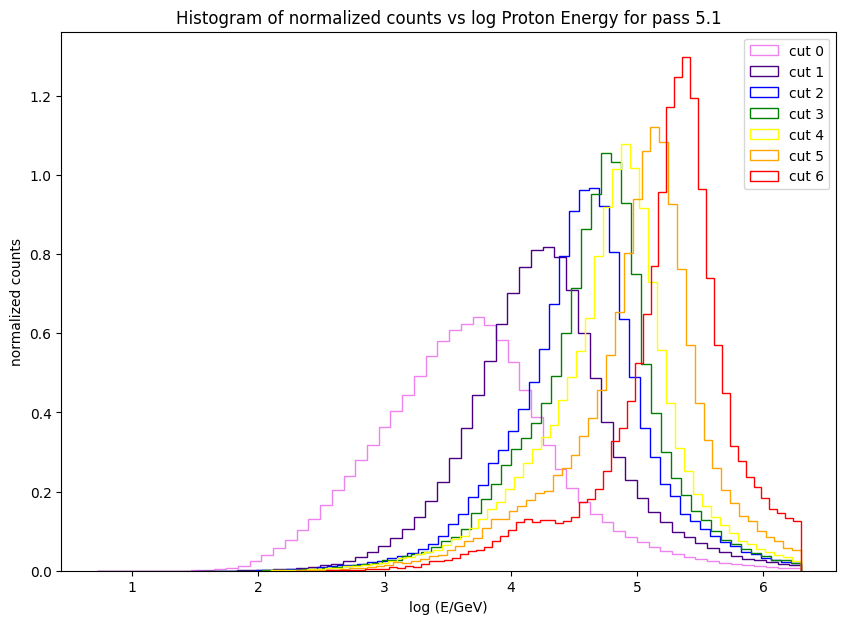

In [69]:
# normalizing the counts for pass 5.1 - rec proton energy
make_normalized_histogram(prot_energies_5, hist_colors_m2, "Histogram of normalized counts vs log Proton Energy for pass 5.1")

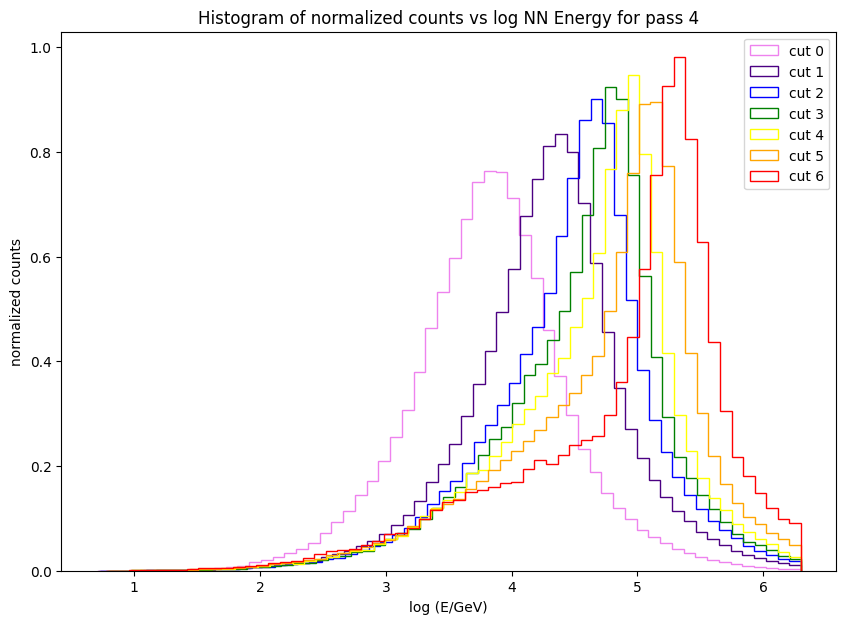

In [70]:
# normalizing the counts for pass 4 - rec nn energy
make_normalized_histogram(nn_energies_4, hist_colors_m2, "Histogram of normalized counts vs log NN Energy for pass 4")

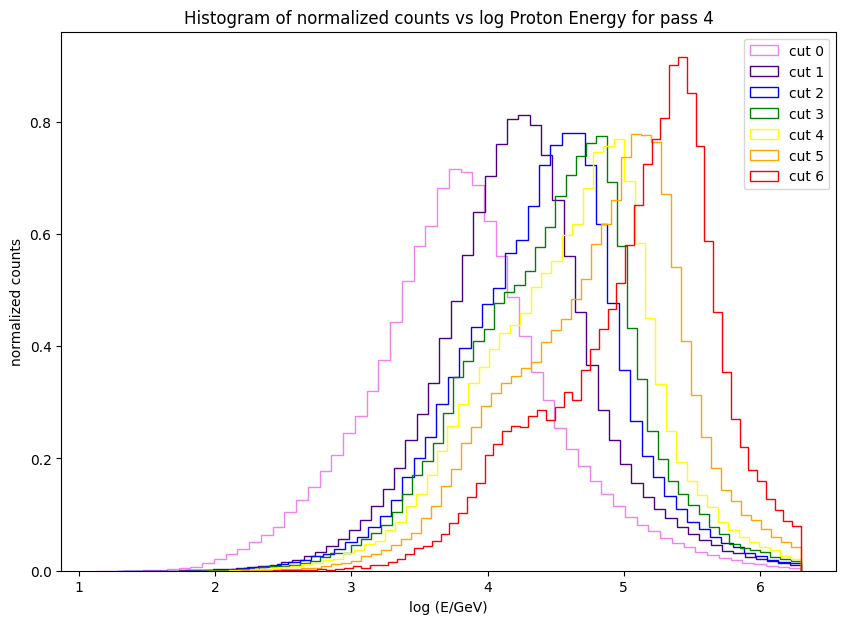

In [71]:
# normalizing the counts for pass 4 - rec proton energy
make_normalized_histogram(prot_energies_4, hist_colors_m2, "Histogram of normalized counts vs log Proton Energy for pass 4")

# Plotting the equation

\$ \frac{d \log{\phi} (E)}{\log{E}} = \gamma_{1} + (\gamma_{2} - \gamma_{1}) \frac{\left( \frac{E}{E_{o}} \right)^{\varepsilon}}{1 + \left( \frac{E}{E_{o}} \right)^{\varepsilon}}  \$

In [40]:
g1 = -2.52
g2 = -2.71
E0 = 3.87e4
eps = 3
def func(E):
    y = g1 + (g2 - g1)*((((E)/E0)**eps)/(1 + ((E)/E0)**eps))
    return y

In [41]:
specind1 = func(10**(true_log_E_5))

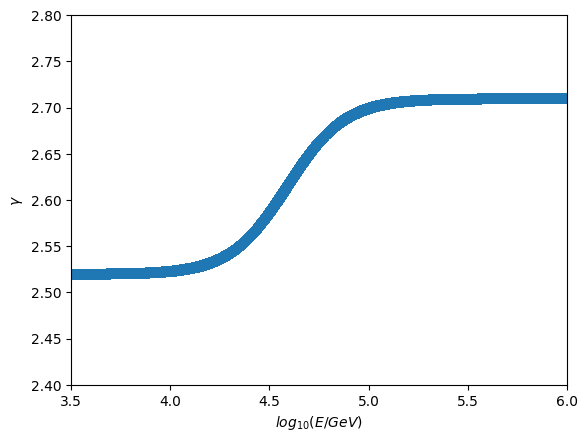

In [42]:
# true energy

plt.scatter(true_log_E_5, np.abs(specind1))
plt.ylim(2.4, 2.8)
plt.xlim(3.5,6)
plt.xlabel("$ log_{10} (E/GeV) $")
plt.ylabel("$ \gamma $")
plt.show()

In [ ]:
# def make_energy_histo(dataset, bin_sizes, emin=1, emax=6, coszenmin=0.3,coszenmax=1, nhitmin=1.5,nhitmax=3.1 ,title="HAWC Energy Response"):
    
#     coszen_bins = np.linspace(0.3,1,bin_sizes['coszen'])
#     hit_bins = np.linspace(1.5,3.1,bin_sizes['nhit'])
#     ebins = np.linspace(emin, emax, bin_sizes['energy'])
#     nx, ny, ne = len(coszen_bins)-1, len(hit_bins)-1, len(ebins)-1

#     #h = (np.zeros((2, nx, ny, ne)), [[0,1,2], coszen_bins, hit_bins, ebins])
#     h = (np.zeros((nx, ny, ne)), [coszen_bins, hit_bins, ebins])
#     cuts = dataset["mc"]["cuts"]
#     #cuts = dataset["mc"]["logEnergy"]>.9
#     energy = dataset["mc"]["protonlheEnergy"][cuts]-9
#     zenith = dataset["mc"]["zenithAngle"][cuts]
#     weights = dataset["mc"]["weights"][cuts]
#     pinc = dataset["mc"]["PINC"][cuts]
#     cxpe40x = dataset["mc"]["CxPE40XnCh"][cuts]
#     mcenergy = dataset["mc"]["logEnergy"][cuts]
#     nhit = dataset["mc"]["nHit"][cuts]


#     d = {"zenith":zenith, "energy": mcenergy, "nhit":nhit}

#     histo = fillHist(h, d, weights,validation = False,nfiles=1)

#     #print(histo)
#     h, bins = histo

#     xbins, ybins, zbins = bins
#     #ebins = getEbins() + [8]

#         # Calculate spline / median energy values
#     energies, sigL, sigR, var = histMedian(h, bins)


#     # Additional options
#     #energies[energies==0] = energies.max()      # 0 events only at high E
#     #  - finer binning for x & y if using splines?
#      #  - cmap.set_under('white')

#      # Plot formatting
#     fig, ax = plt.subplots(figsize=(10,8))
#     #fig, ax = plt.subplots(figsize=(5,4))
#     matplotlib.rc("font", family="serif")
#     tPars = {'fontsize':16}
#     cmap = plt.cm.jet
#     #cmap = cmap_discretize(cmap, ebins)
#     cmap.set_under('white')

#     # Plot
#     X, Y = np.meshgrid(xbins, ybins)
#     p = ax.pcolor(X, Y, energies.T, cmap=cmap, vmin=ebins[0], vmax=ebins[-1])
#     cb = fig.colorbar(p, ax=ax, ticks=ebins)
#     cb.ax.set_yticklabels(['%.2f' % ebin for ebin in ebins])
#     cb.set_label(r'$\mathrm{log}_{10}(E/\mathrm{GeV})$',
#                 rotation=270, labelpad=20, **tPars)
#     ax.set_xlabel(r'$\mathrm{cos}(\theta_\mathrm{reco})$', **tPars)
#     ax.set_ylabel(r'$\mathrm{log}_{10}(N_\mathrm{Hit})$', **tPars)
#     #ax.set_xlim(xbins.min(), xbins.max())
#     #ax.set_ylim(ybins.min(), ybins.max())
#     for item in (ax.get_xticklabels() + ax.get_yticklabels() + cb.ax.get_yticklabels()):
#         item.set_fontsize(16)

#     for item in cb.ax.get_yticklabels():
#         item.set_fontsize(14)
#     plt.title(title)
#     plt.show()